In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
size_train = len(train_data)
dataset = pd.concat([train_data, test_data]).reset_index(drop=True)

In [4]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
dataset.sample(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
921,922,NaN,2,"Louch, Mr. Charles Alexander",male,50.0,1,0,SC/AH 3085,26.0000,NaN,S
808,809,0.0,2,"Meyer, Mr. August",male,39.0,0,0,248723,13.0000,NaN,S
448,449,1.0,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
703,704,0.0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q
1105,1106,NaN,3,"Andersson, Miss. Ida Augusta Margareta",female,38.0,4,2,347091,7.7750,NaN,S
250,251,0.0,3,"Reed, Mr. James George",male,NaN,0,0,362316,7.2500,NaN,S
511,512,0.0,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S
304,305,0.0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.0500,NaN,S
1057,1058,NaN,1,"Brandeis, Mr. Emil",male,48.0,0,0,PC 17591,50.4958,B10,C
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S


# EDA

### Age

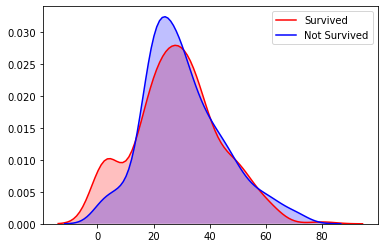

In [6]:
ax = sns.kdeplot(train_data.loc[train_data['Survived']==True, 'Age'], shade=True, color='r')
ax = sns.kdeplot(train_data.loc[train_data['Survived']==False, 'Age'], shade=True, color='b', ax=ax)
ax_legend = ax.legend(['Survived', 'Not Survived'])

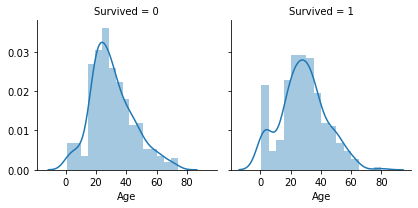

In [7]:
g = sns.FacetGrid(data=train_data, col='Survived')
g = g.map(sns.distplot, 'Age')

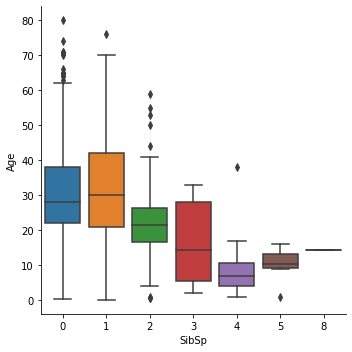

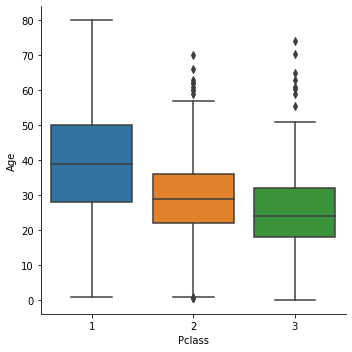

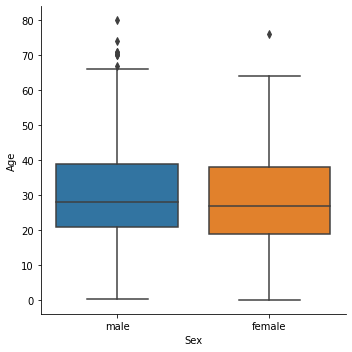

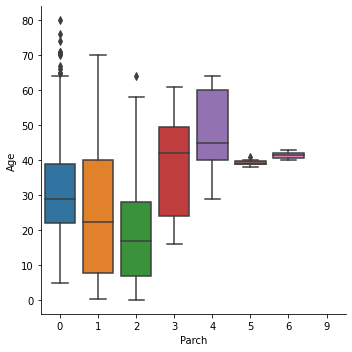

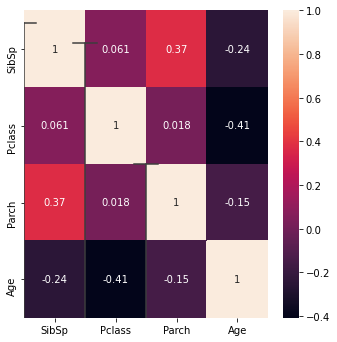

In [8]:
features = ['SibSp', 'Pclass', 'Sex', 'Parch', 'Embarked']
for f in features:
    sns.catplot(x=f, y='Age', data=dataset, kind='box')
sns.heatmap(dataset[features + ['Age']].corr(), annot=True)

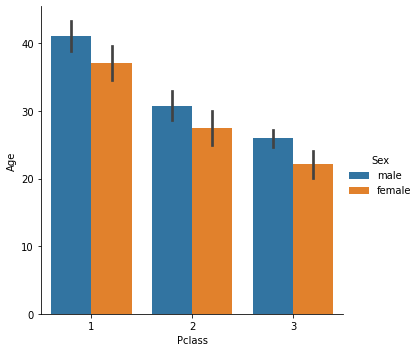

In [9]:
sns.catplot(x='Pclass', y='Age', hue='Sex', data=dataset, kind='bar')

### Fare

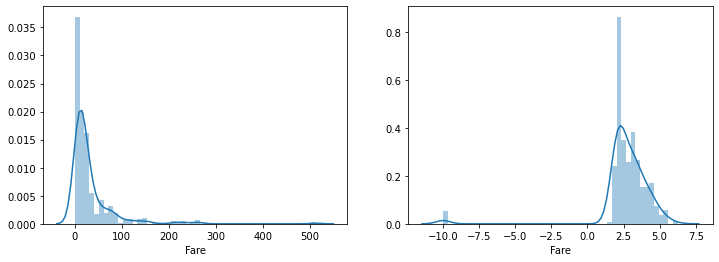

In [10]:
fig = plt.figure(figsize=[12, 4])
axes = fig.subplots(1, 2)
ax = sns.distplot(train_data['Fare'], ax=axes[0])
ax = sns.distplot(train_data['Fare'].map(lambda x: np.log(x) if x > 0 else -10), ax=axes[1])

### Pclass

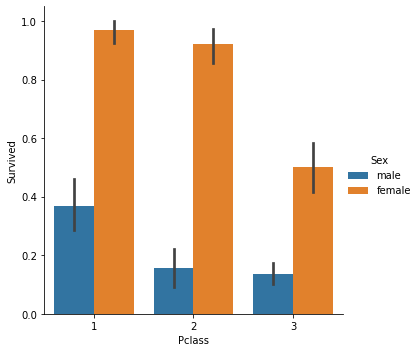

In [11]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train_data, kind='bar')

### Embarked

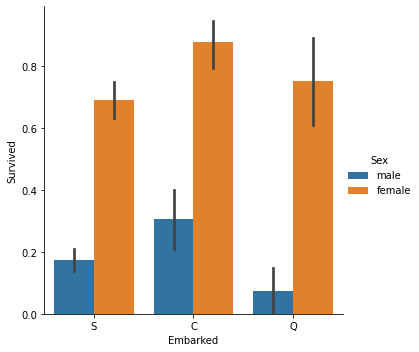

In [12]:
g = sns.catplot(x='Embarked', y='Survived', hue='Sex', data=train_data, kind='bar')

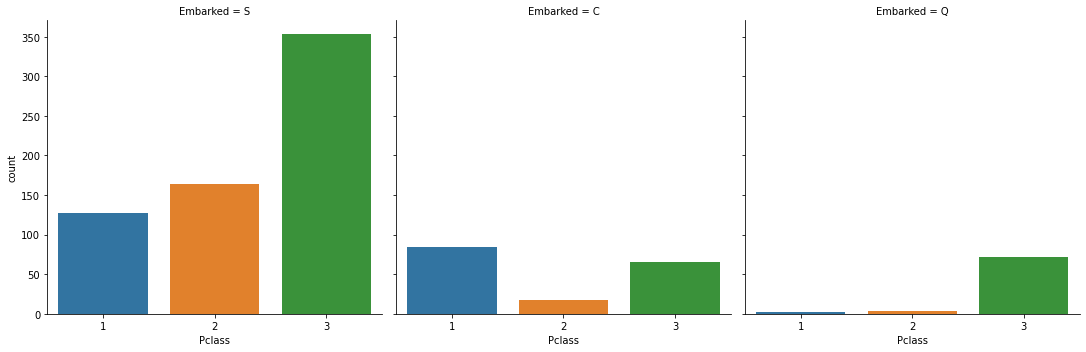

In [13]:
sns.catplot(x='Pclass', col='Embarked', data=train_data, kind='count')

### Family

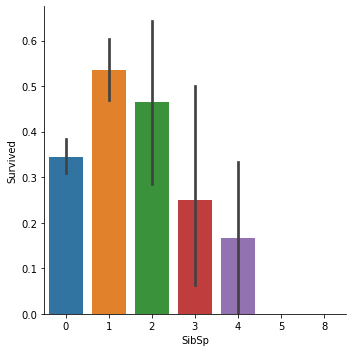

In [14]:
sns.catplot(x='SibSp', y='Survived', data=train_data, kind='bar')

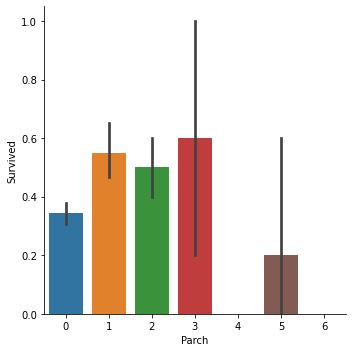

In [15]:
sns.catplot(x='Parch', y='Survived', data=train_data, kind='bar')

### Sex

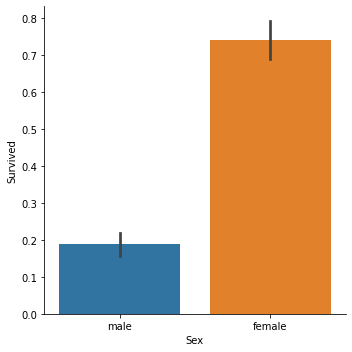

In [16]:
sns.catplot(x='Sex', y='Survived', data=train_data, kind='bar')

## Data processing 

In [17]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

### Age, Fare, Embarked

In [18]:
dataset['Embarked'].fillna('S', inplace=True)

In [19]:
dataset[dataset['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [20]:
dataset['Fare'].fillna(dataset.loc[(dataset['Pclass'] == 3) & (dataset['Embarked'] == 'S'), 'Fare'].median(), inplace=True)

In [21]:
dataset['Age'] = dataset.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [22]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

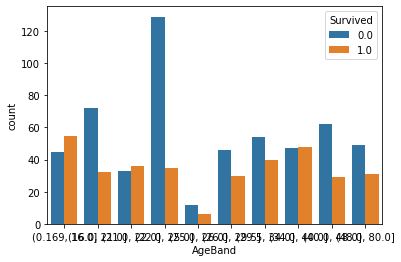

In [23]:
dataset['AgeBand'] = pd.qcut(dataset['Age'], 10)
sns.countplot(x='AgeBand', hue='Survived', data=dataset)

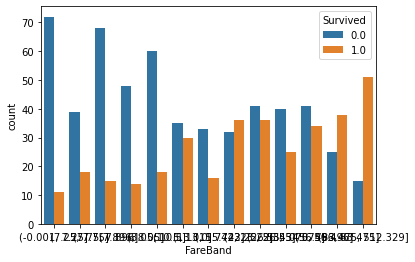

In [24]:
dataset['FareBand'] = pd.qcut(dataset['Fare'], 13)
sns.countplot(x='FareBand', hue='Survived', data=dataset)

### Cabin

In [25]:
dataset['Cabin'] = dataset['Cabin'].str.extract(r'^(\S)', expand=False).fillna('M')

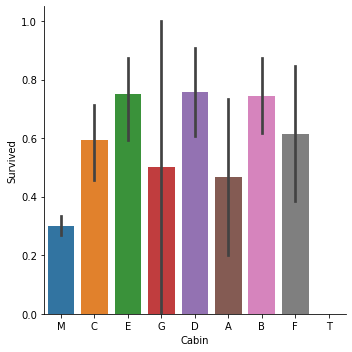

In [26]:
sns.catplot(x='Cabin', y='Survived', data=dataset.loc[:size_train], kind='bar')

In [27]:
dataset['Cabin'].replace(['A', 'B', 'C', 'T'], 'ABC', inplace=True)
dataset['Cabin'].replace(['D', 'E'], 'DE', inplace=True)
dataset['Cabin'].replace(['F', 'G'], 'FG', inplace=True)

### Name

In [28]:
dataset.loc[dataset['Name'].str.contains('\('), 'Name'].sample(20)

1153    Wells, Mrs. Arthur Henry (Addie" Dart Trevaskis)"
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
1253         Ware, Mrs. John James (Florence Louise Long)
765                  Hogeboom, Mrs. John C (Anna Andrews)
968     Cornell, Mrs. Robert Clifford (Malvina Helen L...
1256                       Sage, Mrs. John (Annie Bullen)
1075    Douglas, Mrs. Frederick Charles (Mary Helene B...
799     Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...
161     Watt, Mrs. James (Elizabeth "Bessie" Inglis Mi...
1259              Gibson, Mrs. Leonard (Pauline C Boeson)
9                     Nasser, Mrs. Nicholas (Adele Achem)
939       Bucknell, Mrs. William Robert (Emma Eliza Ward)
608     Laroche, Mrs. Joseph (Juliette Marie Louise La...
1090              Rasmussen, Mrs. (Lena Jacobsen Solvang)
1131            Lindstrom, Mrs. Carl Johan (Sigrid Posse)
546                     Beane, Mrs. Edward (Ethel Clarke)
101                      Petroff, Mr. Pastcho ("Pentcho")
15            

In [29]:
dataset['Surname'] = dataset['Name'].str.extract(r'^([^,]+),', expand=False)
dataset['Title'] = dataset['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
dataset['Title'].replace(['Ms', 'Mlle', 'Countess', 'Lady', 'Dona', 'Mme'], 'Miss', inplace=True)
dataset['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Rev', 'Don', 'Sir'], 'Noble', inplace=True)

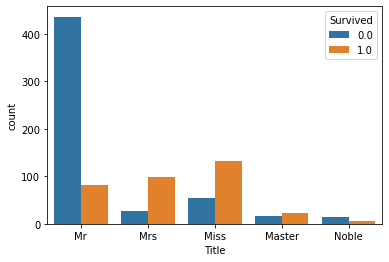

In [30]:
sns.countplot(x='Title', hue='Survived', data=dataset[:size_train])

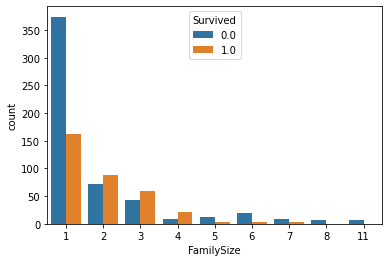

In [31]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
sns.countplot(x='FamilySize', hue='Survived', data=dataset)

In [32]:
dataset.loc[dataset['FamilySize'] == 1, 'FamilyType'] = 'Alone'
dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] < 5), 'FamilyType'] = 'Small'
dataset['FamilyType'].fillna('Large', inplace=True)

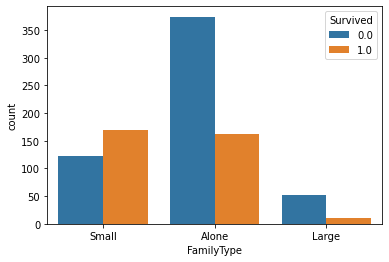

In [33]:
sns.countplot(x='FamilyType', hue='Survived', data=dataset)

In [34]:
surname_survived = dataset[:size_train].groupby('Surname')['Survived'].mean().to_dict()
surname_count = dataset[:size_train].groupby('Surname')['Survived'].count().to_dict()

In [35]:
average_mean = dataset['Survived'].mean()
dataset['SurnameSurvived'] = dataset['Surname'].transform(lambda x: surname_survived[x] if x in surname_count.keys() and surname_count[x] > 1 else average_mean)
dataset['SurnameSurvivedisNA'] = dataset['Surname'].transform(lambda x: 0 if x in surname_count.keys() and surname_count[x] > 1 else 1)
# TODO: Check a family exists in both training and test set, and has members more than 1

### Ticket

In [36]:
ticket_survived = dataset[:size_train].groupby('Ticket')['Survived'].mean().to_dict()
ticket_freq = dataset.groupby('Ticket')['Ticket'].count().to_dict()
# dataset['TicketSurvived'] = dataset['Ticket'].map(ticket_survived)
# dataset['TicketSurvivedisNA'] = dataset['TicketSurvived'].isna().astype(np.int)
# dataset['TicketSurvived'].fillna(0, inplace=True)
dataset['TicketFreq'] = dataset['Ticket'].map(ticket_freq)

### Finalize

In [37]:
dataset.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Surname', 'FamilySize'], axis='columns', inplace=True)

In [38]:
dataset.sample(20)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,AgeBand,FareBand,Title,FamilyType,SurnameSurvived,SurnameSurvivedisNA,TicketFreq
224,225,1.0,1,male,38.0,90.0000,ABC,S,"(34.0, 40.0]","(83.475, 512.329]",Mr,Small,0.666667,0,2
68,69,1.0,3,female,17.0,7.9250,M,S,"(16.0, 21.0]","(7.896, 8.05]",Miss,Large,0.222222,0,1
1275,1276,NaN,2,male,29.5,12.8750,M,S,"(26.0, 29.5]","(10.5, 13.0]",Mr,Alone,0.383838,1,1
1161,1162,NaN,1,male,46.0,75.2417,ABC,C,"(40.0, 48.0]","(56.496, 83.475]",Mr,Alone,0.383838,1,2
223,224,0.0,3,male,25.0,7.8958,M,S,"(22.0, 25.0]","(7.75, 7.896]",Mr,Alone,0.000000,1,1
1270,1271,NaN,3,male,5.0,31.3875,M,S,"(0.169, 16.0]","(26.55, 34.075]",Master,Large,0.750000,0,7
1142,1143,NaN,3,male,20.0,7.9250,M,S,"(16.0, 21.0]","(7.896, 8.05]",Mr,Alone,0.383838,1,1
91,92,0.0,3,male,20.0,7.8542,M,S,"(16.0, 21.0]","(7.75, 7.896]",Mr,Alone,0.000000,1,1
98,99,1.0,2,female,34.0,23.0000,M,S,"(29.5, 34.0]","(15.742, 23.25]",Mrs,Small,1.000000,0,2
1206,1207,NaN,3,female,17.0,7.7333,M,Q,"(16.0, 21.0]","(7.25, 7.75]",Miss,Alone,0.383838,1,1


In [39]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

dataset = pd.get_dummies(dataset, columns=['Pclass'])
dataset = pd.get_dummies(dataset, columns=['FamilyType'])
dataset = pd.get_dummies(dataset, columns=['Cabin'])
dataset = pd.get_dummies(dataset, columns=['Embarked'])
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset['Sex'] = LabelEncoder().fit_transform(dataset['Sex'])
dataset['AgeBand'] = LabelEncoder().fit_transform(dataset['AgeBand'])
dataset['FareBand'] = LabelEncoder().fit_transform(dataset['FareBand'])

## Start training

In [40]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

In [41]:
y = dataset.iloc[:size_train]['Survived']
X = dataset.iloc[:size_train].drop(columns=['Survived', 'PassengerId'], axis=1)
X_test = dataset.iloc[size_train:].drop(columns=['Survived', 'PassengerId'], axis=1)

In [42]:
X.iloc[:10, :10]

,Sex,Age,Fare,AgeBand,FareBand,SurnameSurvived,SurnameSurvivedisNA,TicketFreq,Pclass_1,Pclass_2
0,1,22.0,7.2500,2,0,0.000000,0,1,0,0
1,0,38.0,71.2833,7,11,1.000000,1,2,1,0
2,0,26.0,7.9250,4,3,1.000000,1,1,0,0
3,0,35.0,53.1000,7,10,0.500000,0,2,1,0
4,1,35.0,8.0500,7,3,0.500000,0,1,0,0
5,1,25.0,8.4583,3,4,0.333333,0,1,0,0
6,1,54.0,51.8625,9,10,0.000000,1,2,1,0
7,1,2.0,21.0750,0,7,0.000000,0,5,0,0
8,0,27.0,11.1333,5,5,0.500000,0,3,0,0
9,0,14.0,30.0708,0,9,0.500000,0,2,0,1


In [43]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=47, n_jobs=-1, verbose=1)
model_rf.fit(X, y)
results = pd.DataFrame({'PassengerId': dataset.iloc[size_train:]['PassengerId'], 'Survived': model_rf.predict(X_test).astype(np.int)})
results.to_csv('submission_0805_rf.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


## Finish

In [1]:
clfs = []
random_state = 7
clfs.append(RandomForestClassifier(random_state=random_state))
clfs.append(AdaBoostClassifier(random_state=random_state))
clfs.append(GradientBoostingClassifier(random_state=random_state))
clfs.append(DecisionTreeClassifier(random_state=random_state))
clfs.append(ExtraTreeClassifier(random_state=random_state))
clfs.append(LogisticRegression(random_state=random_state))
clfs.append(SVC(random_state=random_state))
clfs.append(MLPClassifier(random_state=random_state))
clfs.append(LinearDiscriminantAnalysis())

clfs_names = ['RF', 'AdaBoost', 'GB', 'DT', 'ExtraTree', 'LR', 'SVC', 'MLP', 'LDA']
clfs_scores = []
kfold = StratifiedKFold(n_splits=10)
for clf in clfs:
    clfs_scores.append(cross_val_score(clf, X, y, scoring='accuracy', cv=kfold, n_jobs=-1, verbose=1))

NameError: name 'RandomForestClassifier' is not defined

In [2]:
cv_scores = pd.DataFrame({k: v for k, v in zip(clfs_names, clfs_scores)}).unstack().to_frame()
sns.barplot(x=cv_scores.index.get_level_values(0), y=cv_scores[0])
cv_scores.groupby(cv_scores.index.get_level_values(0)).mean().sort_values(by=0)

NameError: name 'pd' is not defined

In [3]:
clf = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100,200,300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1],}
gsc_gb = GridSearchCV(clf, gb_param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_gb.fit(X, y)
gb_best = gsc_gb.best_estimator_
gb_best_score = gsc_gb.best_score_

NameError: name 'GradientBoostingClassifier' is not defined

In [4]:
clf = LogisticRegression()
param_grid = {'penalty': ['l2', 'l1'],
              'C': [1e-2, 1e-1, 1., 10., 100.]}
gsc_lr = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_lr.fit(X, y)
lr_best = gsc_lr.best_estimator_
lr_best_score = gsc_lr.best_score_

NameError: name 'LogisticRegression' is not defined

In [5]:
clf = MLPClassifier()
param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'learning_rate_init': [1e-2, 1e-3, 1e-4]}
gsc_nn = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_nn.fit(X, y)
nn_best = gsc_nn.best_estimator_
nn_best_score = gsc_nn.best_score_

NameError: name 'MLPClassifier' is not defined

In [6]:
clf = LinearDiscriminantAnalysis()
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': [None, 'auto']}
gsc_lda = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_lda.fit(X, y)
lda_best = gsc_lda.best_estimator_
lda_best_score = gsc_lda.best_score_

NameError: name 'LinearDiscriminantAnalysis' is not defined

In [7]:
clf = RandomForestClassifier()
param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}
gsc_rf = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
gsc_rf.fit(X, y)
rf_best = gsc_rf.best_estimator_
rf_best_score = gsc_rf.best_score_

NameError: name 'RandomForestClassifier' is not defined

In [8]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('GB', gb_best), ('LR', lr_best), ('MLP', nn_best), ('LDA', lda_best), ('RF', rf_best)], voting='soft', n_jobs=-1)
vc = vc.fit(X, y)

In [41]:
results = pd.DataFrame({'PassengerId': dataset.iloc[size_train:]['PassengerId'], 'Survived': vc.predict(X_test).astype(np.int)})
results.to_csv('submission_0804_ensemble.csv', index=False)

In [46]:
rf_best_score

0.8372908863920099